# trainer test

### import module

In [9]:
import os
import numpy as np
import pickle
from tqdm import tqdm

In [1]:
import flaxmodels
# import dm_pix
import jax.numpy as jnp
import jax
from flax import jax_utils
import wandb

from flax.training import common_utils
from utils.dataloader import mel_dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
import flax.linen as nn
import random



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

In [3]:
data = mel_dataset('/mnt/disks/sdb/dataset', 'total')

Load song_meta.json...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707989/707989 [00:00<00:00, 771787.90it/s]


Load complete!

Load file list...


710it [02:05,  5.66it/s]


In [4]:
len(data)

611323

In [26]:
from trainer import AudioEncoderTrainer
from model.Base_encoder import AudioEncoder

# data = mel_dataset('/home/anthonypark6904/dataset', 'total')


    


In [94]:
def contrastive_collate_batch(batch):
    x_train = [spec_mask(np.array(np.expand_dims(x, axis= -1))) for x, _ in batch]
    
    y_train = [y for _, y in batch]           

    return np.stack(x_train + x_train, axis=0), np.array(y_train)

dataset_size = len(data)
train_size = int(dataset_size * 0.8)    
test_size = dataset_size - train_size

train_dataset, test_dataset, = random_split(data, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=contrastive_collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=contrastive_collate_batch)



In [95]:
train_iter = next(iter(train_dataloader))


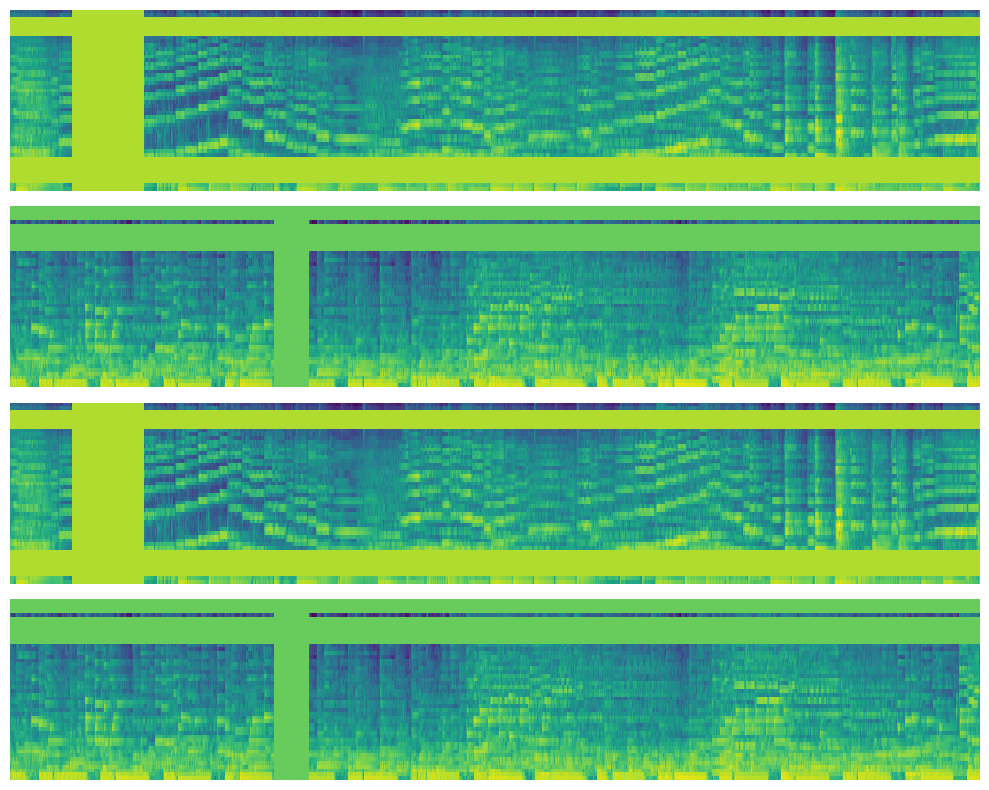

In [96]:
fig, ax = plt.subplots(4, figsize = (10, 8))
axes = ax.flatten()
for i in range(4):
    axes[i].imshow(train_iter[0][i], aspect='auto', origin='lower', interpolation='none')
    axes[i].axis('off')
plt.tight_layout()

In [27]:
trainer = AudioEncoderTrainer(exmp=jnp.ones((64, 48, 1876, 1)))

# trainer.train_model(train_dataloader, test_dataloader, num_epochs=3)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/anthonypark6904/.netrc


---

In [26]:
rng = jax.random.PRNGKey(42)
outs = AudioEncoder().apply({'params': trainer.state.params},
                        batch, 
                        rngs={"dropout": rng},
                        mutable=['batch_stats'])
print(outs[0])

(DeviceArray(4.2078795, dtype=float32), {'loss': DeviceArray(4.2078795, dtype=float32), 'acc_top1': DeviceArray(0.015625, dtype=float32), 'acc_top5': DeviceArray(0.078125, dtype=float32), 'acc_mean_pos': DeviceArray(38.09375, dtype=float32)})


In [17]:
(loss, metrics), new_model_state = outs 

In [19]:
loss

DeviceArray(4.2078795, dtype=float32)

In [20]:
metrics

{'loss': DeviceArray(4.2078795, dtype=float32),
 'acc_top1': DeviceArray(0.015625, dtype=float32),
 'acc_top5': DeviceArray(0.078125, dtype=float32),
 'acc_mean_pos': DeviceArray(38.09375, dtype=float32)}

In [10]:
wandb.finish()

acc_mean_pos,▃▂▅▅▃▄▁▄▅▃▄▃▃▅▃▁▃▃▂█▃▆▅▆▁▃▄▄▅▅▄▅▆▃▂▃▄▇▂▅
acc_top1,▅▅▁▃▅▆▆▃▃▅█▃▃▁▅█▁▃▅▁▃▁▃▁▅▃▃▅▁▁▃▃▃▃█▅▅▁▅▃
acc_top5,▄▅▅▄▇▄▅▄▁▇▂▅▅▂█▇▇▅▇▁▅▄▅▂▇▅▅▄▅▄▄▄▅▄▅▅▅▁▇▄
loss,▇▁▇▇▅▇▃▅▆▄▆▅▆▆▆▄▆▆▅█▅▇▆▇▅▆▅▆▆▆▆▆▇▇▅▆▆▇▄▇
acc_mean_pos,4.875
acc_top1,0.125
acc_top5,0.5
loss,1.96567


In [14]:
feats.shape

(8, 512)

In [16]:
feats[:,None,:].shape

(8, 1, 512)

In [17]:
feats[None,:,:].shape

(1, 8, 512)

In [18]:
import optax

In [19]:
cos_sim = optax.cosine_similarity(feats[:,None,:], feats[None,:,:])
cos_sim.shape

NameError: name 'feats' is not defined

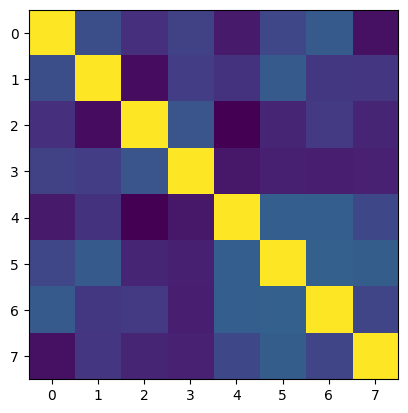

In [42]:
plt.imshow(cos_sim)

In [43]:
cos_sim /= 0.07
cos_sim

DeviceArray([[14.285713 ,  7.492537 ,  6.611048 ,  7.069218 ,  6.0043335,
               7.2471867,  7.8702745,  5.747783 ],
             [ 7.492537 , 14.285714 ,  5.6655226,  6.9817924,  6.6834254,
               7.8740783,  6.8000326,  6.775267 ],
             [ 6.611048 ,  5.6655226, 14.285714 ,  7.7065706,  5.359695 ,
               6.2864203,  6.8616652,  6.2818904],
             [ 7.069218 ,  6.9817924,  7.7065706, 14.285712 ,  5.924318 ,
               6.150078 ,  6.108083 ,  6.1786804],
             [ 6.0043335,  6.6834254,  5.359695 ,  5.924318 , 14.285714 ,
               8.037983 ,  8.031783 ,  7.3051324],
             [ 7.2471867,  7.8740783,  6.2864203,  6.150078 ,  8.037983 ,
              14.285714 ,  8.083088 ,  7.9871707],
             [ 7.8702745,  6.8000326,  6.8616652,  6.108083 ,  8.031783 ,
               8.083088 , 14.285714 ,  7.2243996],
             [ 5.747783 ,  6.775267 ,  6.2818904,  6.1786804,  7.3051324,
               7.9871707,  7.2243996, 14.285713 ]],

In [44]:
diag_range = jnp.arange(feats.shape[0], dtype=jnp.int32)
diag_range

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

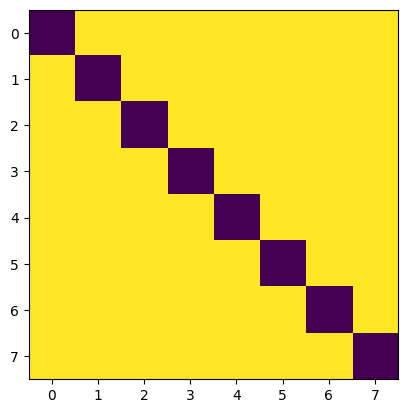

In [45]:
cos_sim = cos_sim.at[diag_range, diag_range].set(-9e15)
plt.imshow(cos_sim)

In [49]:
shifted_diag = jnp.roll(diag_range, batch.shape[0]//2)
print(diag_range)
print(shifted_diag)

[0 1 2 3 4 5 6 7]
[4 5 6 7 0 1 2 3]


In [12]:
a = np.array([[1, 2, 3, 4], 
              [5, 6, 7, 8], 
              [1, 2, 3, 4]])

In [13]:
a_range = jnp.arange(a.shape[0], dtype=jnp.int32)
a_range


DeviceArray([0, 1, 2], dtype=int32)

In [ ]:
[0, 1, 2]
[0, 1, 2]

In [20]:
a[a_range, a_range]

array([1, 6, 3])

In [48]:
pos_logits = cos_sim[diag_range, shifted_diag]
pos_logits

DeviceArray([6.0043335, 7.8740783, 6.8616652, 6.1786804, 6.0043335,
             7.8740783, 6.8616652, 6.1786804], dtype=float32)

In [53]:
jax.nn.logsumexp(cos_sim, axis=-1)

DeviceArray([9.0424185, 9.031368 , 8.611511 , 8.740272 , 9.154026 ,
             9.569199 , 9.44221  , 8.98844  ], dtype=float32)

In [55]:
nll = - pos_logits + jax.nn.logsumexp(cos_sim, axis=-1)
nll.mean()

DeviceArray(2.342741, dtype=float32)

In [ ]:
cos_sim = optax.cosine_similarity(feats[:,None,:], feats[None,:,:])
cos_sim /= self.temperature
diag_range = jnp.arange(feats.shape[0], dtype=jnp.int32)
cos_sim = cos_sim.at[diag_range, diag_range].set(-9e15)

shifted_diag = jnp.roll(diag_range, x.shape[0]//2)
pos_logits = cos_sim[diag_range, shifted_diag]

# InfoNCE loss
nll = - pos_logits + nn.logsumexp(cos_sim, axis=-1)
nll = nll.mean()

# Logging
metrics = {'loss': nll}
# Determine ranking position of positive example
comb_sim = jnp.concatenate([pos_logits[:,None],
                            cos_sim.at[shifted_diag, diag_range].set(-9e15)],
                           axis=-1)
sim_argsort = (-comb_sim).argsort(axis=-1).argmin(axis=-1)

# Logging of ranking position
metrics['acc_top1'] = (sim_argsort == 0).mean()
metrics['acc_top5'] = (sim_argsort < 5).mean()
metrics['acc_mean_pos'] = (sim_argsort + 1).mean()

In [24]:
len(batch)

8